In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir("drive/MyDrive/02456-protein-project2020/notebooks")

In [3]:
! pip install Biopython

     |████████████████████████████████| 2.3MB 17.1MB/s 


In [4]:
# import general libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython import display
import torch.nn.functional as F


# import my functions
from training_functions import Dataset, my_collate
from data_functions import get_inputs_targets_from_sequences,\
 get_train_test, organize_fasta_header, IUPAC_VOCAB
from networks import Gru

In [5]:
# read in table from uniprot with info and sequences
name = "BL-cytoC_mix_bidir_GRU"
data=pd.read_csv("data/BL-cytoC_mix.tsv",sep='\t') #make sure you have updated the value above 
n_seq=data.shape[0]
data.head(n=2)

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Protein families,Taxonomic lineage (ALL),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Taxonomic lineage (CLASS),Taxonomic lineage (FAMILY),Taxonomic lineage (FORMA),Taxonomic lineage (GENUS),Taxonomic lineage (INFRACLASS),Taxonomic lineage (all),Beta strand,Helix,Turn,Mass,Cross-reference (Pfam),Sequence,Taxonomic lineage (PHYLUM),seq_len
0,P00004,CYC_HORSE,reviewed,Cytochrome c,CYCS CYC,Equus caballus (Horse),105,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, M...",apoptotic process [GO:0006915]; cytochrome c-h...,cytochrome complex [GO:0070069]; cytosol [GO:0...,cytochrome complex [GO:0070069]; cytosol [GO:0...,"electron transporter, transferring electrons f...",GO:0005758; GO:0005829; GO:0006122; GO:0006123...,Mammalia,Equidae (horses),NaN,Equus,NaN,"cellular organisms, Eukaryota, Opisthokonta, M...","STRAND 22..24; /evidence=""ECO:0000244|PDB:5IY...","HELIX 4..14; /evidence=""ECO:0000244|PDB:6K9J""...","TURN 15..18; /evidence=""ECO:0000244|PDB:6K9J""...","11,833",PF00034;,MGDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPG...,Chordata,105
1,P62897,CYC_MOUSE,reviewed,"Cytochrome c, somatic",Cycs,Mus musculus (Mouse),105,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, M...",activation of cysteine-type endopeptidase acti...,cytosol [GO:0005829]; mitochondrial intermembr...,cytosol [GO:0005829]; mitochondrial intermembr...,"electron transporter, transferring electrons f...",GO:0005634; GO:0005739; GO:0005758; GO:0005829...,Mammalia,Muridae,NaN,Mus,NaN,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,NaN,NaN,"11,605",PF00034;,MGDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAAG...,Chordata,105


In [6]:
data["Protein families"].value_counts()

Cytochrome c family                                                  4634
Cytochrome c family, PsbV subfamily                                  1005
Cytochrome c family, PetJ subfamily                                   986
Hcp beta-lactamase family                                             900
Class-C beta-lactamase family                                         900
Class-A beta-lactamase family                                         900
LysR transcriptional regulatory family                                900
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     900
Class-D beta-lactamase family                                         900
Metallo-beta-lactamase superfamily, Glyoxalase II family              900
Binding-protein-dependent transport system permease family            900
Peptidase S12 family, YfeW subfamily                                  900
Name: Protein families, dtype: int64

In [8]:
# get indices for train/test split
train_idx, test_idx=get_train_test(list(range(n_seq)), list(range(n_seq)), train_frac=0.9)

# select train/test splits in table
train_table = data.iloc[train_idx[0]]
test_table = data.iloc[test_idx[0]]

# add <unk> and quote each letter #
### obs! require that sequenecs are longer than 20 and shorter than 500 
# train 
train_seq=train_table["Sequence"].to_list()
train_seq=[list(seq) for seq in train_seq] 
_=[seq.append("<unk>") for seq in train_seq]


# test 
test_seq=test_table["Sequence"].to_list()
test_seq=[list(seq) for seq in test_seq]
_=[seq.append("<unk>") for seq in test_seq]

## get inputs and targets 
inputs_train, targets_train=get_inputs_targets_from_sequences(train_seq)
inputs_test, targets_test=get_inputs_targets_from_sequences(test_seq)

In [9]:
#convert AA to letters using dictionary
# targets =Y, inputs = X
# train 
targets_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_train]
inputs_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_train]
# test - for estimation of test error 
targets_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_test]
inputs_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_test]
# test for investigaing embedding 
test_full_seq = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in test_seq]

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
len(inputs_train_num)

13252

# Define GRU bidirectional network

In [12]:
class BIGru(nn.Module):
    def __init__(self, vocab, n_layers, hidden_size, batch_size, embedding_dim=10):
        super(BIGru, self).__init__()
        self.vocab_size=len(vocab.values())
        self.vocab = vocab
        self.n_layers=n_layers
        self.hidden_size = hidden_size
        self.batch_size=batch_size
        self.dropout = nn.Dropout(p=0.5)
        self.embedding_dim = embedding_dim

        # Recurrent layer

        padding_idx = self.vocab['<pad>']
        self.word_embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=padding_idx
        )


        self.linear1 = nn.Linear(in_features = self.embedding_dim, out_features=30)
        self.linear2 = nn.Linear(in_features = 30, out_features=40)

        self.gru = nn.GRU(input_size=40,
                         hidden_size=self.hidden_size,
                         num_layers=self.n_layers,
                         bidirectional=True,dropout=0.5)
        


        # Output layer
        self.l_out = nn.Linear(in_features=self.hidden_size*2,
                            out_features=self.vocab_size,
                            bias=False)
        
    def forward(self, x):
        """x: packed sequence"""
        ps=None
        if type(x)==torch.nn.utils.rnn.PackedSequence:
            ps=True
            x, seq_len= torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=False)
        
        x = self.word_embedding(x)
        x=self.dropout(F.relu(self.linear1(x)))
        x=self.dropout(F.relu(self.linear2(x)))

        if ps:
            x=torch.nn.utils.rnn.pack_padded_sequence(x, seq_len, enforce_sorted=False)
        
        if not ps:
            x=x.reshape(-1,1,40)

        # RNN returns output and last hidden state
        x, h = self.gru(x)
        
        # tilføj relu
        
        if type(x)==torch.nn.utils.rnn.PackedSequence:
            x, seq_len= torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        x=F.relu(x)

        # Flatten output for feed-forward layer
        x = x.view(-1, self.gru.hidden_size*2)

        # Output layer
        x = self.l_out(x)

        x = x.view(-1, self.vocab_size)
        x = F.log_softmax(x, dim=1)

        # print(x.shape)
        return x, h



# Train network

In [13]:
# prepare training and test data 
train_size = len(inputs_train)
test_size=len(inputs_test)
batch_size=32
train1 = Dataset(inputs_train_num[:train_size], targets_train_num[:train_size])
test1 = Dataset(inputs_test_num[:test_size], targets_test_num[:test_size])
# we define the dataloader for the training data 
trainloader = DataLoader(train1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

testloader = DataLoader(test1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

In [14]:
# set initialvalues 
vocab_size=len(IUPAC_VOCAB)
n_layers=10
hidden_size=50
max_iter = 600
eval_every = 25
log_every=50


In [16]:
inputs

NameError: ignored

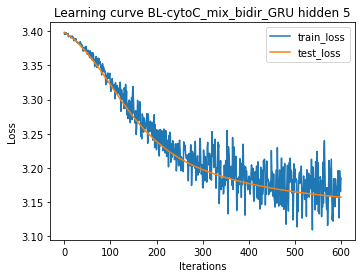

In [17]:

# define the neural network
net = BIGru(n_layers=n_layers, hidden_size=hidden_size, batch_size=batch_size, vocab=IUPAC_VOCAB)
net.to(device)

# define loss and optimizer 
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001) 

# Track loss
stats = { 'test_loss': [], "train_loss":[], "test_iter":[], "train_iter":[]} 

i=0
while i<max_iter:
  for j,(inputs, targets, data) in enumerate(trainloader):

        if i % eval_every == 0:
          test_loss=0
          net.eval()
          # For each sentence in validation set
          for inputs_test, targets_test, data in testloader:
              inputs_test, targets_test = inputs_test.to(device), targets_test.to(device)
              outputs, h=net(inputs_test)

              # reshape the targets for use in loss function
              targets_test_f=[item for sublist in targets_test for item in sublist]
              targets_test_flat = torch.LongTensor(targets_test_f).to(device)  
        
              tag_pad_token=0
              mask = (targets_test_flat > tag_pad_token).float()
              nb_tokens = int(torch.sum(mask).item())
  
              # pick the values for the label and zero out the rest with the mask
              outputs = outputs[range(outputs.shape[0]), targets_test_flat] * mask

              # compute cross entropy loss which ignores all <PAD> tokens
              loss = -(torch.sum(outputs) / nb_tokens)
        
              # Update loss
              test_loss += loss.detach().cpu().numpy()

          stats["test_iter"].append(i)
          stats["test_loss"].append(test_loss/len(testloader))



        ###########
        # TRAIN
        ###########
        net.train()
        optimizer.zero_grad() 

        inputs, targets = inputs.to(device), targets.to(device)

        # predict using the model 
        outputs, h=net(inputs)
        
        # reshape the targets for use in loss function
        targets_f=[item for sublist in targets for item in sublist]
        targets_flat = torch.LongTensor(targets_f).to(device) 
        
        
        tag_pad_token=0
        mask = (targets_flat > tag_pad_token).float()
        nb_tokens = int(torch.sum(mask).item()) # data[0]
        # pick the values for the label and zero out the rest with the mask
        outputs = outputs[range(outputs.shape[0]), targets_flat] * mask
        loss = -(torch.sum(outputs) / nb_tokens)
        
        # Backward pass
        loss.backward() # get gradients 
        optimizer.step()
        
        # Update loss
        #epoch_training_loss += loss.detach().cpu().numpy()
        stats["train_loss"].append(loss.detach().cpu().numpy())
        stats["train_iter"].append(i)

        # Print loss every 10 iterations
        #if i % 10 == 0:
        #  print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')


        # Log i figure
        if i % log_every == 0:
          fig = plt.figure(figsize=(12,4))
          plt.subplot(1, 2, 1)
          plt.title("Learning curve {} hidden {}".format(name, hidden_size))
          plt.plot(stats["train_iter"], stats["train_loss"], label='train_loss')
          plt.plot(stats["test_iter"], stats["test_loss"], label='test_loss')
          plt.legend()
          plt.xlabel('Iterations')
          plt.ylabel('Loss')
          fig.savefig("visualization/learning_curves/CE_{}".format(name))
          plt.show()
          display.clear_output(wait=True)

          #print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')
          #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))

        if i>max_iter:
          break
        i+=1

In [ ]:
import pandas as pd
test_table_num=test_table.to_numpy()

# save the trained network for later 
PATH = '{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
print(PATH)

BL-cytoC_mix_bidir_GRU_b_32_train13252_iter600_hidden5.pth


In [ ]:
torch.save({
    'state_dict':   net.state_dict(), 
    'stats':        stats,
    'args':         {"batch_size": batch_size, "n_layers":n_layers, "hidden_size":hidden_size, "vocab":IUPAC_VOCAB},
    'test_full':    test_full_seq,
    "test_table":    (test_table_num,test_table.columns),
    "train_info":   {"optim":optimizer, "max_iter":max_iter},
    "train_size":   train_size,
    "train_idx":    train_idx,
    "test_idx":     test_idx,
},  "models/{}".format(PATH), _use_new_zipfile_serialization=False)

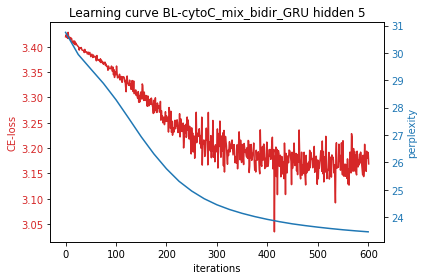

In [ ]:
# x-axis 
iter = stats["train_iter"]

# Create some mock data
val_perplexity = np.exp(stats["test_loss"])

fig, ax1 = plt.subplots()
plt.title("Learning curve {} hidden {}".format(name, hidden_size))

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('CE-loss', color=color)
ax1.plot(iter, stats["train_loss"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(stats["test_iter"], val_perplexity, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.title("Learning curve {}".format("name")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.xlim(0,200)
#plt.show()
plt.savefig("visualization/learning_curves/train_{}_bidirectional_hidden{}".format(name, hidden_size))

# Visualize embedding 

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns 

In [ ]:
pth=torch.load("models/{}_b_{}_train{}_iter{}_hidden{}.pth".format(name,batch_size, train_size, max_iter, hidden_size), map_location=torch.device('cpu'))
stats = pth["stats"]
test_info = pd.DataFrame(pth["test_table"][0], columns=pth["test_table"][1])
test = pth["test_full"]
n_layers = pth["args"]["n_layers"]

In [ ]:
net=BIGru(**pth["args"])
net.load_state_dict(pth["state_dict"])
net.eval()

BIGru(
  (dropout): Dropout(p=0.5, inplace=False)
  (word_embedding): Embedding(30, 10, padding_idx=0)
  (linear1): Linear(in_features=10, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=40, bias=True)
  (gru): GRU(40, 5, num_layers=10, dropout=0.5, bidirectional=True)
  (l_out): Linear(in_features=10, out_features=30, bias=False)
)

In [ ]:
emb_last=[]
emb_mean=[]
emb_max=[]
for i in range(0, len(test)):
    _,h=net(test[i])
    a=h[n_layers-1].detach().numpy()[0]
    b=h[2*n_layers-1].detach().numpy()[0]
    emb_last.append(np.hstack([a,b]))
    
    emb_mean.append(h.mean(dim=0).detach().numpy()[0])
    emb_max.append(h.max(dim=0)[0].detach().numpy()[0])

In [ ]:
emb_last2D = TSNE(n_components=2).fit_transform(emb_last)
emb_mean2D = TSNE(n_components=2).fit_transform(emb_mean)
emb_max2D = TSNE(n_components=2).fit_transform(emb_max)

In [ ]:
# save embedding to eg. asses via downstream task 
emb_save={"emb_last":emb_last, "emb_mean":emb_mean, "emb_max":emb_max, "emb_last2D":emb_last2D, "emb_mean2D":emb_mean2D, "emb_max2D":emb_max2D, "metadata":test_info}

PATH = 'embeddings/emb_{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
PATH

'embeddings/emb_BL-cytoC_mix_bidir_GRU_b_32_train13252_iter600_hidden5.pth'

In [ ]:
torch.save(emb_save, PATH, _use_new_zipfile_serialization=False)

In [ ]:
test_info.columns


Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Protein families', 'Taxonomic lineage (ALL)',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ontology (GO)',
       'Gene ontology (molecular function)', 'Gene ontology IDs',
       'Taxonomic lineage (CLASS)', 'Taxonomic lineage (FAMILY)',
       'Taxonomic lineage (FORMA)', 'Taxonomic lineage (GENUS)',
       'Taxonomic lineage (INFRACLASS)', 'Taxonomic lineage (all)',
       'Beta strand', 'Helix', 'Turn', 'Mass', 'Cross-reference (Pfam)',
       'Sequence', 'Taxonomic lineage (PHYLUM)', 'seq_len'],
      dtype='object')

In [ ]:
test_info["Protein families"].value_counts()

Cytochrome c family                                                  444
Cytochrome c family, PsbV subfamily                                  111
Hcp beta-lactamase family                                            106
Cytochrome c family, PetJ subfamily                                  103
Metallo-beta-lactamase superfamily, Glyoxalase II family              99
Binding-protein-dependent transport system permease family            97
Peptidase S12 family, YfeW subfamily                                  94
LysR transcriptional regulatory family                                92
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     89
Class-D beta-lactamase family                                         82
Class-C beta-lactamase family                                         80
Class-A beta-lactamase family                                         76
Name: Protein families, dtype: int64

In [ ]:
test_info["Taxonomic lineage (all) splitted"]=test_info["Taxonomic lineage (all)"].str.split(", ")

# get the different taxonomic levels for plotting
level3=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[2])
level2=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[1])
#level4=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[3])



test_info["Protein families"].value_counts()

Cytochrome c family                                                  444
Cytochrome c family, PsbV subfamily                                  111
Hcp beta-lactamase family                                            106
Cytochrome c family, PetJ subfamily                                  103
Metallo-beta-lactamase superfamily, Glyoxalase II family              99
Binding-protein-dependent transport system permease family            97
Peptidase S12 family, YfeW subfamily                                  94
LysR transcriptional regulatory family                                92
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     89
Class-D beta-lactamase family                                         82
Class-C beta-lactamase family                                         80
Class-A beta-lactamase family                                         76
Name: Protein families, dtype: int64

In [ ]:
test_info["split"]="beta lactamase"
test_info.loc[test_info["Protein families"].str.contains("Cytochrome c"), 'split'] = 'Cytochrome c'
test_info.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Protein families,Taxonomic lineage (ALL),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Taxonomic lineage (CLASS),Taxonomic lineage (FAMILY),Taxonomic lineage (FORMA),Taxonomic lineage (GENUS),Taxonomic lineage (INFRACLASS),Taxonomic lineage (all),Beta strand,Helix,Turn,Mass,Cross-reference (Pfam),Sequence,Taxonomic lineage (PHYLUM),seq_len,Taxonomic lineage (all) splitted,split
0,P81280,CYC_ALLMI,reviewed,Cytochrome c,NaN,Alligator mississippiensis (American alligator),105,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,mitochondrial intermembrane space [GO:0005758]...,mitochondrial intermembrane space [GO:0005758]...,electron transfer activity [GO:0009055]; heme ...,GO:0005758; GO:0009055; GO:0020037; GO:0046872...,NaN,Alligatoridae,NaN,Alligator,NaN,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,NaN,NaN,"11,624",PF00034;,MGDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLIGRKTGQAPG...,Chordata,105,"[cellular organisms, Eukaryota, Opisthokonta, ...",Cytochrome c
1,W1DNP6,W1DNP6_KLEPN,unreviewed,"Arginine ABC transporter, permease protein ArtQ",NaN,Klebsiella pneumoniae IS43,238,Binding-protein-dependent transport system per...,"cellular organisms, Bacteria, Proteobacteria, ...",nitrogen compound transport [GO:0071705],ATP-binding cassette (ABC) transporter complex...,ATP-binding cassette (ABC) transporter complex...,transmembrane transporter activity [GO:0022857],GO:0022857; GO:0043190; GO:0071705,Gammaproteobacteria,Enterobacteriaceae,NaN,Klebsiella,NaN,"cellular organisms, Bacteria, Proteobacteria, ...",NaN,NaN,NaN,"26,183",PF00528;,MNEIFPLASAAGMTVGLAVCALVIGLVLAMLFAVLESVKWRPVAWL...,Proteobacteria,238,"[cellular organisms, Bacteria, Proteobacteria,...",beta lactamase
2,A0A0C2KZH3,A0A0C2KZH3_9CYAN,unreviewed,Cytochrome c-550 (Cytochrome c550) (Low-potent...,psbV SD81_17170,Tolypothrix campylonemoides VB511288,163,"Cytochrome c family, PsbV subfamily","cellular organisms, Bacteria, Terrabacteria gr...",cytochrome c-heme linkage [GO:0018063]; photos...,photosystem II [GO:0009523]; thylakoid membran...,photosystem II [GO:0009523]; thylakoid membran...,electron transfer activity [GO:0009055]; heme ...,GO:0005506; GO:0009055; GO:0009523; GO:0018063...,NaN,Tolypothrichaceae,NaN,Tolypothrix,NaN,"cellular organisms, Bacteria, Terrabacteria gr...",NaN,NaN,NaN,"17,984",PF14495;,MFRRLFGIFAVTVLLTFQFIVGSATAVELDEATRTVPLNENGETLV...,Cyanobacteria,163,"[cellular organisms, Bacteria, Terrabacteria g...",Cytochrome c
3,A0A1Z5T9G3,A0A1Z5T9G3_HORWE,unreviewed,Cytochrome c,BTJ68_07905,Hortaea werneckii EXF-2000,113,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, F...",NaN,mitochondrial intermembrane space [GO:0005758]...,mitochondrial intermembrane space [GO:0005758]...,electron transfer activity [GO:0009055]; heme ...,GO:0005758; GO:0009055; GO:0020037; GO:0046872...,Dothideomycetes,Teratosphaeriaceae,NaN,Hortaea,NaN,"cellular organisms, Eukaryota, Opisthokonta, F...",NaN,NaN,NaN,"12,527",PF00034;,MGKDSFSEVTGDSKKGANLFKTRCQQCHNLKAEEGNKIGPNLHGLF...,Ascomycota,113,"[cellular organisms, Eukaryota, Opisthokonta, ...",Cytochrome c
4,Q4SCF4,Q4SCF4_TETNG,unreviewed,"Chromosome 1 SCAF14655, whole genome shotgun s...",GSTENG00020521001,Tetraodon nigroviridis (Spotted green pufferfi...,218,Hcp beta-lactamase family,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,mitochondrial intermembrane space [GO:0005758],mitochondrial intermembrane space [GO:0005758],NaN,GO:0005758,Actinopteri,Tetraodontidae (puffers),NaN,Tetraodon,Teleostei,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,NaN,NaN,"23,961",PF08238;,MAGLINFEDENEVKQFLDNLGIEYSFQCYKEKDPEGCQRLADYLEG...,Chordata,218,"[cellular organisms, Eukaryota, Opisthokonta, ...",beta lactamase


Text(0, 0.5, 'y axis')

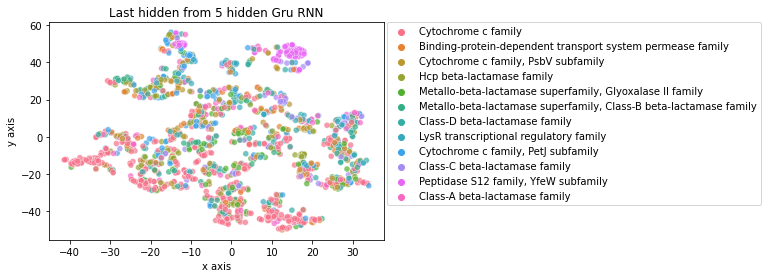

In [ ]:
# visualize pfam 
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

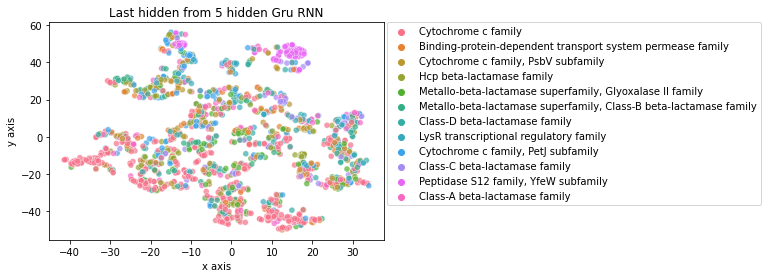

In [ ]:
# visualize pfam 
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")
#plt.savefig("visualization/embedding/50hidden_gru_pfam_CytoC-BL.png", bbox_inches="tight")

Text(0, 0.5, 'y axis')

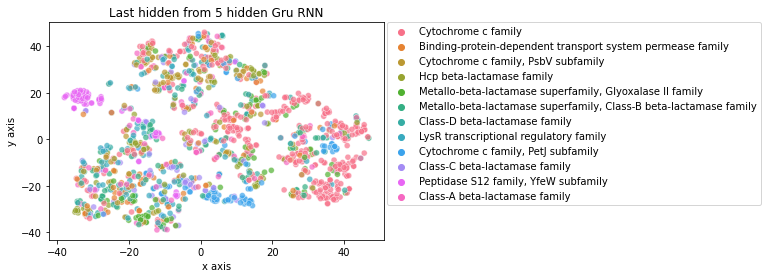

In [ ]:
# visualize pfam 
sns.scatterplot(x=emb_mean2D[:,0], y=emb_mean2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

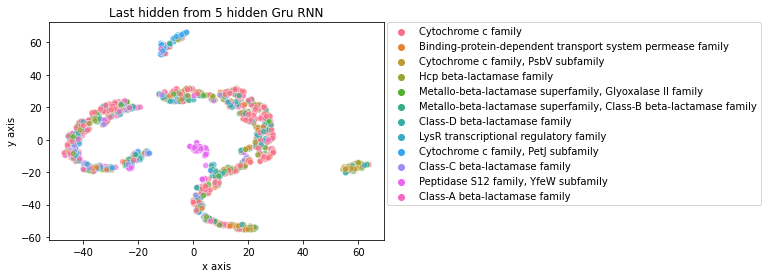

In [ ]:
# visualize pfam 
sns.scatterplot(x=emb_max2D[:,0], y=emb_max2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")